<a href="https://colab.research.google.com/github/Deepak-Mewada/NeuroAI-NMA/blob/main/tutorials/W2D1_Macrocircuits/student/W2D1_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Depth vs width

**Week 2, Day 1: Macrocircuits**

**By Neuromatch Academy**

__Content creators:__ Gabriel Mel de Fontenay

__Content reviewers:__ Surya Ganguli, Xaq Pitkow, Hlib Solodzhuk, Aakash Agrawal, Alish Dipani, Hossein Rezaei, Yousef Ghanbari, Mostafa Abdollahi, Patrick Mineault

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk


___


# Tutorial Objectives

*Estimated timing of tutorial: 1 hour*

In this tutorial we will take a closer look at the expressivity of neural networks by observing the following:

- The **universal approximator theorem** guarantees that we can approximate any complex function using a network with a single hidden layer. The catch is that the approximating network might need to be extremely *wide*.
- We will explore this issue by constructing a complex function and attempting to fit it with shallow networks of varying widths.
- To create this complex function, we'll build a random deep neural network. This is an example of the **student-teacher setting**, where we attempt to fit a known *teacher* function (the deep network) using a *student* model (the shallow/wide network).
- We will find that the deep teacher network can be either very easy or very hard to approximate and that the difficulty level is related to a form of **chaos** in the network activities.
- Each layer of a neural network can effectively expand and fold the input it receives from the previous layer. This repeated expansion and folding grants deep neural networks models high **expressivity** - ie. allows them to implement a large number of different functions.

Let's get started!

In [1]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
link_id = "9n4fj"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/9n4fj/


---
# Setup



In [2]:
# @title Install and import feedback gadget

!pip install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()


feedback_prefix = "W2D1_T1"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.4 MB/s eta 0:00:00


In [3]:
# @title Imports

#working with data
import numpy as np

#plotting
import matplotlib.pyplot as plt
import logging
import matplotlib.patheffects as path_effects

#interactive display
import ipywidgets as widgets
from tqdm.notebook import tqdm as tqdm

#modeling
import torch
import torch.nn as nn

In [4]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Plotting functions

def plot_loss(Es):
    """
    Plot loss progression over time.

    Inputs:
    - Es (np.ndarray): sequence of loss values during training.
    """
    with plt.xkcd():
        plt.semilogy(Es_deep)
        plt.xlabel('Epochs')
        plt.ylabel('Error')
    plt.title("Loss")
    plt.show()

def plot_loss_as_function_of_width(Ws_student, Es_test, Es_train):
    """
    Plot final loss of training as the function of the width of the network.
    """
    with plt.xkcd():
        plt.loglog(Ws_student, Es_test, '.-')
        plt.loglog(Ws_student, Es_train[:,-1], '.-')
        plt.legend(['Test', 'Train'])
        plt.xlabel('Width')
        plt.ylabel('Error')
    plt.title("Loss")
    plt.show()

def plot_students_predictions_vs_teacher_values(Es_train, X_test, y_test):
    """
    Plot loss progression over the time and predicted values of student after training versus true ones generated from teacher.

    Inputs:
    - Es_train (np.ndarray): loss values.
    - X_test (np.ndarray): test input data.
    - y_test (np.ndarray): test outpu data.
    """
    with plt.xkcd():
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        plt.locator_params(nbins=3)

        axes[0].semilogy(Es_train/float(y_test.var()))
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Error')

        axes[1].scatter(y_test.detach(),student(X_test).detach())
        axes[1].set_xlabel('Teacher')
        axes[1].set_ylabel('Student')

        axes[1].tick_params(axis='y', labelrotation=90)
        axes[1].set_yticks([-0.01,0,0.01])
        axes[1].set_xticks([-0.01,0,0.01])

def expressivity_visualization(layer, projected_traj_1, projected_traj_2, colors):
    """
    Plot projected trajectories for points in the given layer for two different networks.

    Inputs:
    - layer (int): layer of networks to visualize.
    - projected_traj_1 (np.ndarray): standard network projections.
    - projected_traj_2 (np.ndarray): quasilinear network projections.
    - colors (np.ndarray): colors to use in plotting.
    """

    with plt.xkcd():

        fig = plt.figure()
        fig.suptitle(f'Layer {layer}', fontsize=16)

        #standard net
        ax1 = fig.add_subplot(121, projection='3d')
        specific_layer_1 = projected_traj_1[layer]

        for i in range(len(specific_layer_1) - 1):
            ax1.plot([specific_layer_1[i, 0], specific_layer_1[i + 1, 0]], [specific_layer_1[i, 1], specific_layer_1[i + 1, 1]], [specific_layer_1[i, 2], specific_layer_1[i + 1, 2]], color=colors[i])

        for line in ax1.get_lines():
            line.set_path_effects([path_effects.Normal()])

        ax1.set_title('Standard Net')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')

        ax2 = fig.add_subplot(122, projection='3d')
        specific_layer_2 = projected_traj_2[layer]

        for i in range(len(specific_layer_2) - 1):
            ax2.plot([specific_layer_2[i, 0], specific_layer_2[i + 1, 0]], [specific_layer_2[i, 1], specific_layer_2[i + 1, 1]], [specific_layer_2[i, 2], specific_layer_2[i + 1, 2]], color=colors[i])

        for line in ax2.get_lines():
            line.set_path_effects([path_effects.Normal()])

        ax2.set_title('Quasi-Linear Net')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')

        plt.tight_layout()
        plt.show()

In [6]:
# @title Helper functions

def generate_trajectories(W, D, P, sigma_1, sigma_2):
    """
    Generate trajectories for evenly spaced points from unit circle through networks and project them to 3D space.

    Inputs:
    - W (int): width of each layer.
    - D (int): depth of each layer.
    - P (int): number of points from unit circle.
    - sigma_1 (float): standard net standard deviation.
    - sigma_2 (float): quasi-linear net standard deviation.
    """
    #initialize nets
    standard_net = make_MLP(2, W, D)
    initialize_layers(standard_net, sigma_1)

    quasilinear_net = make_MLP(2, W, D)
    initialize_layers(quasilinear_net, sigma_2)

    #sample points from unit circle
    theta = np.linspace(0, 2 * np.pi, P)
    points = np.array([np.cos(theta), np.sin(theta)]).T

    #generate trajectories for first net
    parameters = [param for param in standard_net.parameters()]

    for index in range(len(parameters)):
        if not index:
            traj_1 = [np.tanh(points @ parameters[index].detach().numpy().T)]
        else:
            traj_1.append(np.tanh(traj_1[-1] @ parameters[index].detach().numpy().T))

    #generate trajectories for second net
    parameters = [param for param in quasilinear_net.parameters()]

    for index in range(0, len(parameters)):
        if not index:
            traj_2 = [np.tanh(points @ parameters[index].detach().numpy().T)]
        else:
            traj_2.append(np.tanh(traj_2[-1] @ parameters[index].detach().numpy().T))

    return np.array(traj_1[:-1]), np.array(traj_2[:-1])

In [7]:
# @title Set random seed

import random
import numpy as np

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(seed = 42)

---

# Section 1: Introduction

In this section we will create functions to capture the snippets of code that we will use repeatedly in what follows.

In [8]:
# @title Video 1: Introduction

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'KgsFMiF1Uh0'), ('Bilibili', 'BV1YD421M78R')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)


The [universal approximator theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) (UAT) guarantees that we can approximate any function arbitrarily well using a shallow network - ie. a network with a single hidden layer (figure below, left). So why do we need depth? The "catch" in the UAT is that approximating a complex function with a shallow network can require a very large number of hidden units - ie. the network must be very wide. The inability of shallow networks to efficiently implement certain functions suggests that network depth may be one of the brain's computational "secret sauces".

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D1_Macrocircuits/static/nets.png?raw=true" width="500" alt="Shallow vs deep networks expressivity">

To illustrate this fact, we'll create a complex function and then attempt to fit it with single-hidden-layer neural networks of different widths. What we'll find is that although the UAT guarantees that sufficiently wide networks can approximate our function, the performance will actually not be very good for our shallow nets of modest width.

One easy way to create a complex function is to build a random deep neural network (figure below, right). We then have a teacher network which generates the ground truth outputs, and a student network whose goal is to learn the mapping implemented by the teacher. This approach - known as the **student-teacher setting** - is useful for both computational and mathematical study of neural networks since it gives us complete control of the data generation process. Unlike with real-world data, we know the exact distribution of inputs and correct outputs.

Finally, we will show that depending on the distribution of the weights, a random deep neural network can be either very difficult or very easy to approximate with a shallow network. The "complexity" of the function computed by a random deep network thus depends crucially on the weight distribution. One can actually understand the boundary between hard and easy cases as a kind of boundary between chaos and non-chaos in a certain dynamical system. We will confirm that on the non-chaotic side, a random deep neural network can be effectively approximated by a shallow net. This demonstration will be based on ideas from the paper:

[*Exponential expressivity in deep neural networks through transient chaos*](https://papers.nips.cc/paper_files/paper/2016/hash/148510031349642de5ca0c544f31b2ef-Abstract.html) Poole et al. Neurips (2016).

In [9]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_introduction")

In [10]:
# @title Video 2: Setup

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'skw2TLi9oa8'), ('Bilibili', 'BV1yi421v72o')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [11]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_setup")

## Coding Exercise 1: Create an MLP

The code below implements a function that takes in an input dimension, a layer width, and a number of layers and creates a simple MLP in pytorch. In between each layer, we insert a hyperbolic tangent nonlinearity layer (`nn.Tanh()`).

Convention: Because we will count the input as a layer, a depth of 2 will mean a network with just one hidden layer, followed by the output neuron. A depth of 3  will mean 2 hidden layers, and so on.

In [12]:
# @title Network Implementation

def make_MLP(n_in, W, D, nonlin = 'tanh'):
    """
    Create `nn.Sequnetial()` fully-connected model in pytorch with the given parameters.

    Inputs:
    - n_in (int): input dimension.
    - W (int): width of the network.
    - D (int): depth if the network.
    - nonlin (str, default = "tanh"): activation function to use.

    Outputs:
    - net (nn.Sequential): network.
    """

    #activation function
    if nonlin == 'tanh':
        nonlin = nn.Tanh()
    elif nonlin == 'relu':
        nonlin == nn.ReLU()
    else:
        assert(False)

    # Assemble D-1 hidden layers and one output layer

    #input layer
    layers = [nn.Linear(n_in, W, bias = False), nonlin]
    for i in range(D - 2):
        #linear layer
        layers.append(nn.Linear(W, W, bias = False))
        #activation function
        layers.append(nonlin)
    #output layer
    layers.append(nn.Linear(W, 1, bias = False))

    return nn.Sequential(*layers)

net = make_MLP(10, 3, 2)

Now, we implement an auxiliary function which calculates the number of parameters in the MLP.

In [14]:
def get_num_params(n_in,W,D):
    """
    Simple function to compute number of learned parameters in an MLP with given dimensions.

    Inputs:
    - n_in (int): input dimension.
    - W (int): width of the network.
    - D (int): depth if the network.

    Outputs:
    - num_params (int): number of parameters in the network.
    """
    ###################################################################
    ## Fill out the following then remove
    #raise NotImplementedError("Student exercise: complete function which calculates the number of parameters in the defined architecture of MLP.")
    ###################################################################

    input_params = n_in * W
    hidden_layers_params = (D-2) * W**2
    output_params = W
    return input_params + hidden_layers_params + output_params

np.testing.assert_allclose(get_num_params(10, 3, 2), 33, err_msg = "Expected value of parameters number is different!")

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial1_Solution_bc99a7f9.py)



In [15]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_create_mlp")

## Coding Exercise 2: Initialize model weights

Write a function that, given a model and a $\sigma$, initializes all weights in the model according to a normal distribution with mean $0$ and standard deviation

 $$\frac{\sigma}{\sqrt{n_{in}}},$$

 where $n_{in}$ is the number of inputs to the layer.

In [18]:
set_seed(42)

def initialize_layers(net,sigma):
    """
    Set weight to each of the parameters in the model of value sigma/sqrt(n_in), where n_in is the number of inputs to the layer.

    Inputs:
    - net (nn.Sequential): network.
    - sigma (float): standard deviation.
    """
    ###################################################################
    ## Fill out the following then remove
    #raise NotImplementedError("Student exercise: set initial values to the weights of MLP.")
    ###################################################################
    for param in net.parameters():
        n_in = param.shape[1]
        nn.init.normal_(param, std = sigma/np.sqrt(n_in))

initialize_layers(net, 1)
np.testing.assert_allclose(next(net.parameters())[0][0].item(), 0.6093441247940063, err_msg = "Expected value of parameter is different!")

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial1_Solution_a2d6d2f1.py)



In [19]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_initialize_model_weights")

## Coding Exercise 3: Generate a dataset

Given a network, generate the input data by sampling from a multivariate Gaussian distribution and output data by passing the inputs through the network. Don't forget to `.detach()` the outputs - otherwise, gradients will be computed for these (with respect to the teacher weights, which we don't want).

In [21]:
set_seed(42)

def make_data(net, n_in, n_examples):
    """
    Generate data by sampling from a multivariate gaussian distribution, and output data by passing the inputs through the network.

    Inputs:
    - net (nn.Sequential): network.
    - n_in (int): input dimension.
    - n_examples (int): number of data examples to generate.

    Outputs:
    - X (torch.tensor): input data.
    - y (torch.tensor): output data.
    """
    ###################################################################
    ## Fill out the following then remove
    #raise NotImplementedError("Student exercise: complete data generation.")
    ###################################################################
    X = torch.randn(n_examples, n_in)
    y = net(X).detach()
    return X, y

X, y = make_data(net, 10, 10000000)
np.testing.assert_allclose(X[0][0].item(), 1.9269152879714966, err_msg = "Expected value of data is different!")

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial1_Solution_d81fba1b.py)



In [22]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_generate_dataset")

## Coding Exercise 4: Train model and compute loss

In this coding exercise, write a function that will train a given net on a given dataset. Function parameters include the network, the training inputs and outputs, the number of steps, and the learning rate. Set up loss function as MSE.

In [27]:
set_seed(42)

def train_model(net, X, y, n_epochs, lr, progressbar=True):
    """
    Perform training of the network.

    Inputs:
    - net (nn.Sequential): network.
    - X (torch.tensor): input data.
    - y (torch.tensor): output data.
    - n_epochs (int): number of epochs to train the model for.
    - lr (float): learning rate for optimizer (we will use `Adam` by default).
    - progressbar (bool, default = True): whether to use additional bar for displaying training progress.

    Outputs:
    - Es (np.ndarray): array which contains loss for each epoch.
    """
    ###################################################################
    ## Fill out the following then remove
    #raise NotImplementedError("Student exercise: complete training of the network.")
    ###################################################################

    # Set up optimizer
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)

    # Run training loop
    Es = np.zeros(n_epochs)
    for n in (tqdm(range(n_epochs)) if progressbar else range(n_epochs)):
        y_pred = net(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        Es[n] = float(loss.detach())

    return Es

Es = train_model(net, X, y, 10, 1e-3)
np.testing.assert_allclose(Es[0], 0.0, err_msg = "Expected value of loss is different!")

  0%|          | 0/10 [00:00<?, ?it/s]

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial1_Solution_29135326.py)



### Coding Exercise 4 Discussion

Why do you think we obtain zero error right away (on the first epoch)?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial1_Solution_a955337c.py)



Now, write a helper function that computes the loss of a net on a dataset. It takes the following parameters: the network and the dataset inputs and outputs.

In [30]:
def compute_loss(net, X, y):
    """
    Calculate loss on given network and data.

    Inputs:
    - net (nn.Sequential): network.
    - X (torch.tensor): input data.
    - y (torch.tensor): output data.

    Outputs:
    - loss (float): computed loss.
    """
    ###################################################################
    ## Fill out the following then remove
    #raise NotImplementedError("Student exercise: complete loss calculation.")
    ###################################################################
    loss_fn = nn.MSELoss()

    y_pred = net(X)
    loss = loss_fn(y_pred, y)
    loss = float(loss.detach())
    return loss

loss = compute_loss(net, X, y)
np.testing.assert_allclose(loss, 0.0, err_msg = "Expected value of loss is different!")

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial1_Solution_4929cd6d.py)



In [31]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_train_model_and_compute_loss")

---

# Section 2: Fitting a deep network with a shallow network

Estimated timing to here from start of tutorial: 20 minutes

We will now use the functions we've created to experiment with deep network fitting. In particular, we will see to what extent it is possible to fit a deep net using a shallow net. Specifically, we will fix a deep teacher and then fit it with a single-hidden-layer net with varying width value. In principle, if the number of hidden units is large enough, the error should be low. Let's see!

In [32]:
# @title Video 3: Deep network fit with a shallow network

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'blzAxXqh1EU'), ('Bilibili', 'BV13i421e73V')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [33]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_deep_network_fit_with_a_shallow_network")

## Coding Exercise 5: Create learning problem

Create a "deep" teacher network that accepts inputs of size 5. Give the network a width of 5 and a depth of 5. Use this to generate both a training and test set with 4000 examples for training and 1000 for testing. Initialize weights with a standard deviation of 2.0.

In [35]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete set up.")
###################################################################
torch.manual_seed(-1)

# Create teacher
n_in = 5     # input dimension
W_teacher, D_teacher = 5, 5  # teacher width, depth
sigma_teacher = 0.4     # teacher weight variance
teacher = make_MLP(n_in, W_teacher, D_teacher)
initialize_layers(teacher, sigma_teacher)

# generate train and test set
N_train, N_test = 4000, 1000
X_train, y_train = make_data(teacher,n_in, N_train)
X_test, y_test = make_data(teacher, n_in, N_test)

np.testing.assert_allclose(X_test[0][0].item(), 0.19076240062713623, err_msg = "Expected value of data is different!")

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial1_Solution_8817495d.py)



### Coding Exercise 5 Discussion

1. What is the minimum error achievable by an MLP on the generated problem?
2. What is the minimum error achievable by a 1-hidden-layer MLP?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial1_Solution_166f0c8a.py)



In [36]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_create_learning_problem")

## Coding Exercise 6: Train net with the same architecture

Create a student network with the same architecture as the teacher network - that is, the same width and depth. Train it and confirm that a network with the same architecture can indeed achieve low test error. You may need to train for a large number of iterations, and you may need to adjust the learning rate as learning proceeds.

First, let's confirm that the number of training examples is greater than 3 times the number of parameters, so we have enough data to train the network.

In [37]:
n_in = 5
W_student, D_student = 5, 5
student = make_MLP(n_in, W_student, D_student)

# make sure we have enough data
P = get_num_params(n_in, W_student, D_student)
assert(N_train > 3*P)

Now, let's train the student and observe the loss on a semi-log plot (the y-axis is logarithmic)! Your task is to complete the missing parts of the code. While the model is training training, you can go to the next coding exercise and return back to observe the results (it will take approximately 5 minutes).

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

Loss of deep student:  1.4139858779882764e-06


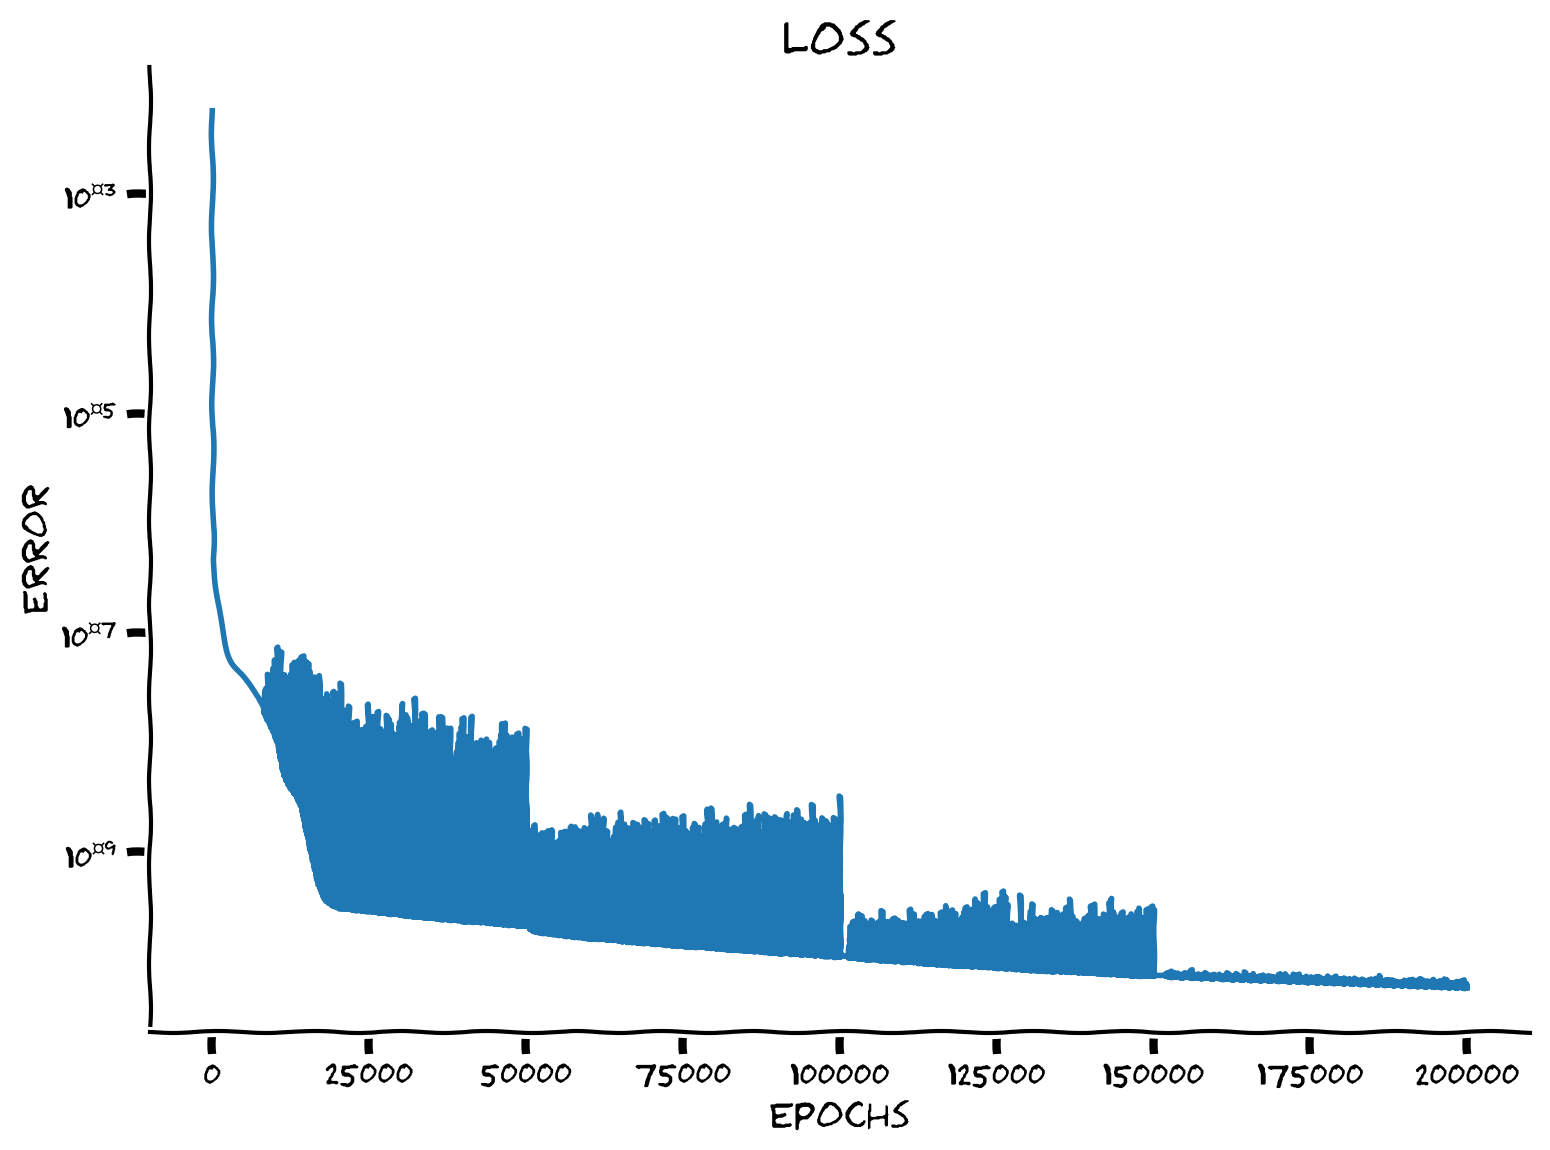

In [39]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: train student on the generated data from teacher.")
###################################################################
lr = 0.003
Es_deep = []
for i in range(4):
    Es_deep.append(train_model(student,X_train, y_train, 50000, lr))
    #observe we reduce learning rate
    lr /= 3
Es_deep = np.array(Es_deep)
Es_deep = Es_deep.ravel()

# evaluate test error
loss_deep = compute_loss(student, X_test, y_test) / float(y_test.var())
print("Loss of deep student: ",loss_deep)
plot_loss(Es_deep)

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial1_Solution_a5e90b35.py)

*Example output:*

<img alt='Solution hint' align='left' width=772.0 height=575.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D1_Macrocircuits/static/W2D1_Tutorial1_Solution_a5e90b35_5.png>



In [40]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_train_net_with_the_same_architecture")

## Coding Exercise 7: Train a 2 layer neural net with varying width

Let us now try to fit the deep teacher network with a shallow student network. Let's give the student a single hidden layer, and let's study the error as a function of the student width $W_s$. For a range of widths between, say, 5 and 200, create a student network, train it on the training set, and compute its test error. The training time will take approximately 2 minutes.

Then, plot the training and testing errors as a function of width on a log-log plot. How does the error of the shallow network compare to that of the deep network?

  0%|          | 0/4 [00:00<?, ?it/s]

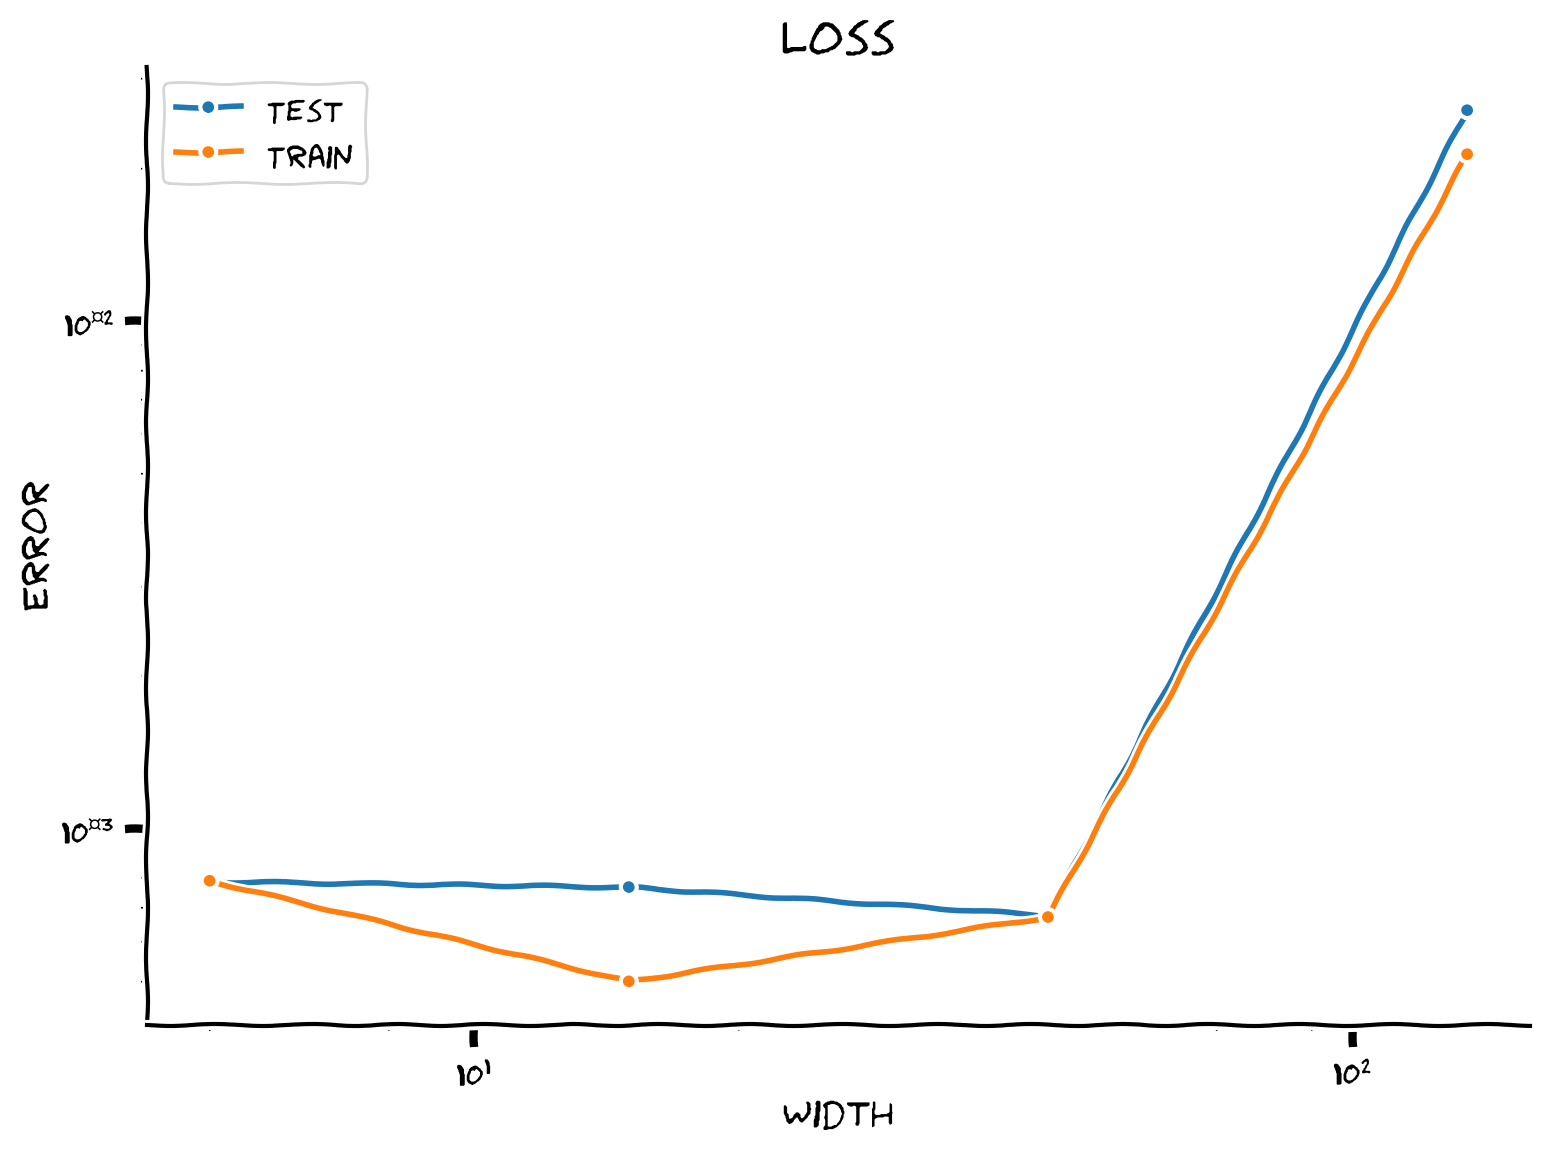

In [42]:
D_student = 2  # student depth
Ws_student = np.array([5, 15, 45, 135]) # widths

lr = 1e-3
n_epochs = 20000
Es_shallow_train = np.zeros((len(Ws_student), n_epochs))
Es_shallow_test = np.zeros(len(Ws_student))

###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: train different students on the already generated data from teacher.")
###################################################################

for index, W_student in enumerate(tqdm(Ws_student)):

    student = make_MLP(n_in, W_student, D_student)

    # make sure we have enough data
    P = get_num_params(n_in, W_student, D_student)
    assert(N_train > 3*P)

    # train
    Es_shallow_train[index] = train_model(student, X_train, y_train, n_epochs, lr, progressbar=False)
    Es_shallow_train[index] /= y_test.var()

    # evaluate test error
    loss = compute_loss(student, X_test, y_test)/y_test.var()
    Es_shallow_test[index] = loss

plot_loss_as_function_of_width(Ws_student, Es_shallow_test, Es_shallow_train)

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial1_Solution_dcafefea.py)

*Example output:*

<img alt='Solution hint' align='left' width=775.0 height=575.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D1_Macrocircuits/static/W2D1_Tutorial1_Solution_dcafefea_1.png>



In [43]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_train_two_layer_net_with_varying_width")

## Coding Exercise 8: Network size prediction

Let's suppose that the test error will continue to improve with increasing width according to the same trend in the previous plot - which is probably too optimistic but will let us do some back-of-the-envelope calculations. Specifically, let us assume there is a linear relationship

$$ \log E=m \log W+b$$
between the log of the width and the log of the error. Fit this linear model from our experiment and use it to predict the number of hidden units needed to achieve a relative error of, say, $10^{-6}$.

In [45]:
error_target = 1e-6

###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: fit linear model and predict the number of hidden units.")
###################################################################

m,b = np.polyfit(np.log(Ws_student), np.log(Es_shallow_test), 1)
print('Predicted width: ', np.exp((np.log(error_target) - b) / m))

Predicted width:  0.009186810047665401


[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial1_Solution_a3e6ddda.py)



Based on this, do you think that a reasonably sized shallow network could learn this task with low error?

In [46]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_network_size_prediction")

---

# Section 3: Deep networks in the quasilinear regime

Estimated timing to here from start of tutorial: 45 minutes

We've just shown that certain deep networks are difficult to fit. In this section, we will discuss a regime in which a shallow network is able to approximate a deep teacher relatively well.

In [47]:
# @title Video 4: Deep networks in the quasilinear regime

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'XuAcOiqJuDs'), ('Bilibili', 'BV1CT421e7Q7')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [48]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_deep_networks_in_the_quasilinear_regime")

One of the reasons that shallow nets cannot fit deep nets, in general, is that random deep nets, in certain regimes, behave like chaotic systems: each layer can be thought of as a single step of a dynamical system, and the number of layers plays the role of the number of time steps. A deep network, therefore, effectively subjects its input to long-time chaotic dynamics, which are, almost by definition, very difficult to predict accurately. In particular, *shallow* nets simply cannot capture the complex mapping implemented by deeper networks without resorting to an astronomical number of hidden units. Another way to interpret this behavior is that the many layers of a deep network repeatedly stretch and fold their inputs, allowing the network to implement a large number of complex functions - an idea known as **expressivity** ([Poole et al. 2016](https://papers.nips.cc/paper_files/paper/2016/hash/148510031349642de5ca0c544f31b2ef-Abstract.html)).

However, in other regimes, for example, when the weights of the teacher network are small, the dynamics implemented by the teacher network are no longer chaotic. In fact, for small enough weights, they are nearly linear. In this regime, we'd expect a shallow network to be able to approximate a deep teacher relatively well.

For more on these ideas, see the paper

[*Exponential expressivity in deep neural networks through transient chaos*](https://papers.nips.cc/paper_files/paper/2016/hash/148510031349642de5ca0c544f31b2ef-Abstract.html) Poole et al. Neurips (2016).

To test this idea, we'll repeat the exercise above, this time initializing the teacher weights with a small $\sigma$, say, $0.4$, so that the teacher network is quasi-linear.

## Coding Exercise 9: Create dataset & Train a student network

Create training and test sets. Initialize the teacher network with $\sigma_{t} = 0.4$.

In [49]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: complete set up.")
###################################################################
torch.manual_seed(-1)

# Create teacher
n_in = 5     # input dimension
W_teacher, D_teacher = 5, 5  # teacher width, depth
sigma_teacher = 0.4     # teacher weight variance
teacher = make_MLP(n_in, W_teacher, D_teacher)
initialize_layers(teacher, sigma_teacher)

# generate train and test set
N_train, N_test = 4000, 1000
X_train, y_train = make_data(teacher, n_in, N_train)
X_test, y_test = make_data(teacher, n_in, N_test)

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial1_Solution_44d1308a.py)



Give the student network a single hidden layer with $10$ units. Train it for a similar amount of time as before. Determine the relative MSE.

  0%|          | 0/20000 [00:00<?, ?it/s]

Shallow student loss:  3.707158604636006e-05


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


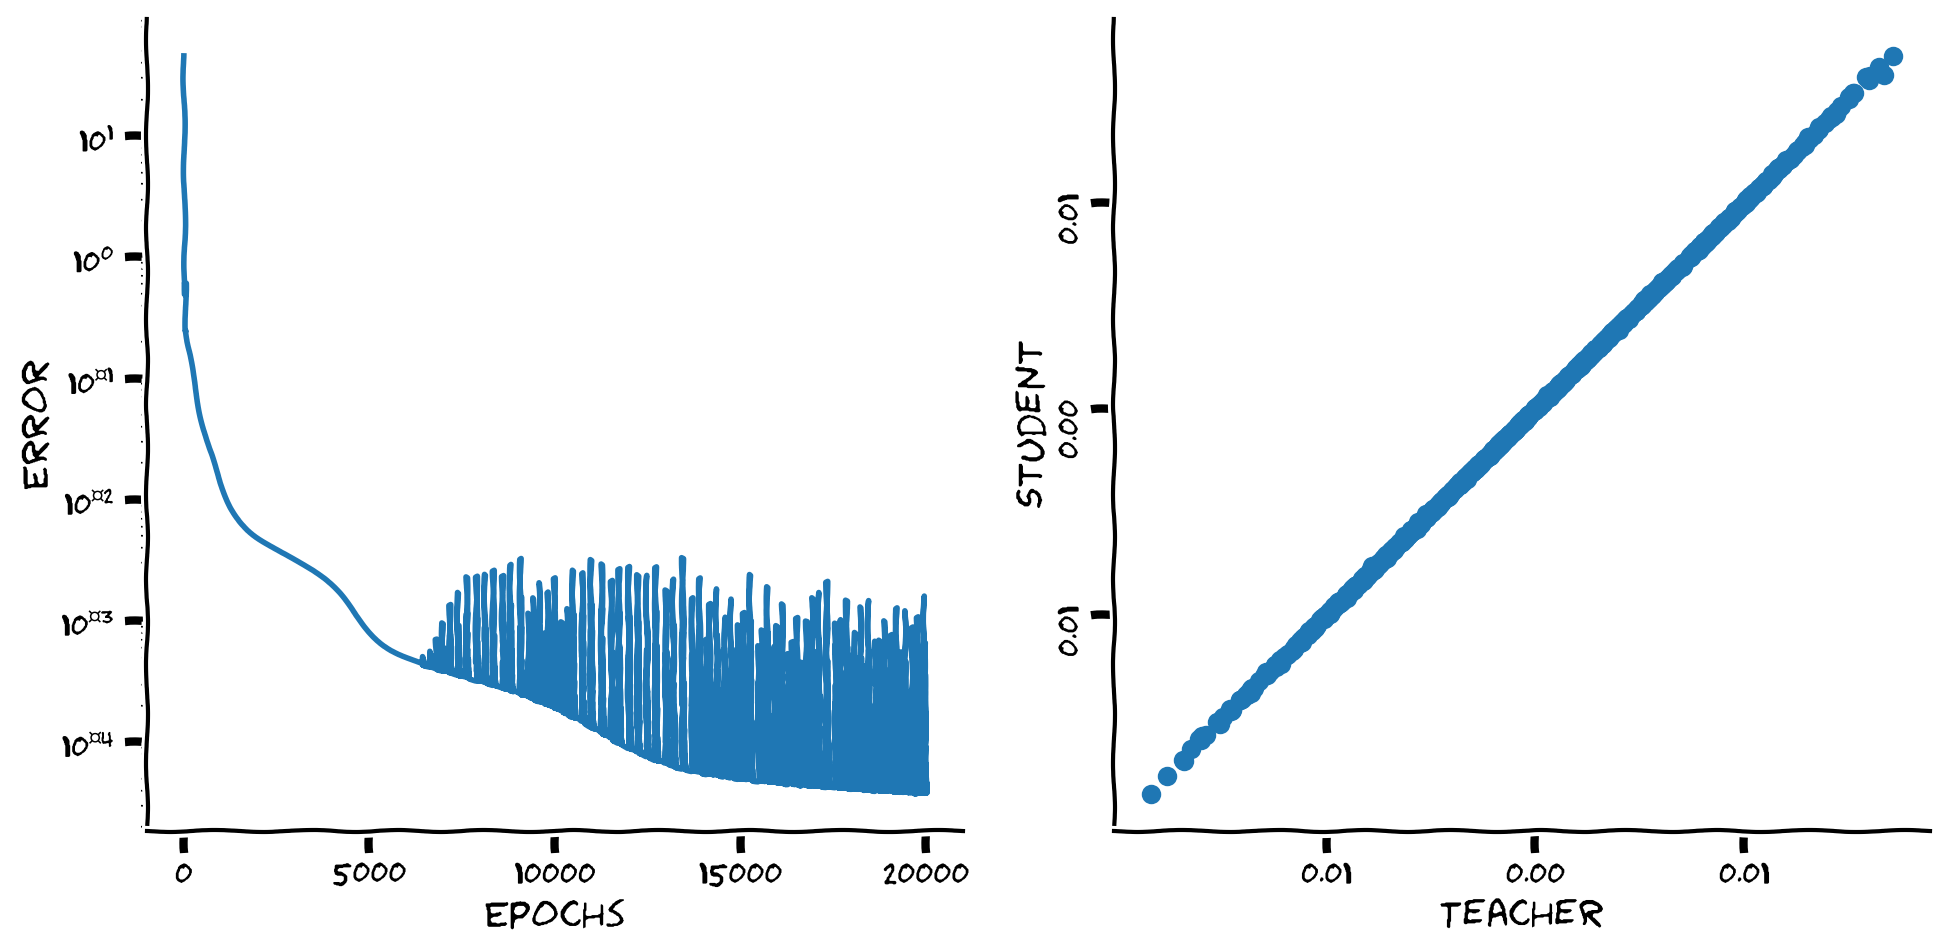

In [52]:
###################################################################
## Fill out the following then remove
#raise NotImplementedError("Student exercise: train student on the generated data from special teacher.")
###################################################################

W_student, D_student = 10, 3  # student width, depth

lr = 1e-3
n_epochs = 20000
Es_shallow_train = np.zeros((len(Ws_student),n_epochs))
Es_shallow_test = np.zeros(len(Ws_student))

student = make_MLP(n_in, W_student, D_student)
initialize_layers(student, sigma_teacher)

# make sure we have enough data
P = get_num_params(n_in, W_student, D_student)
assert(N_train > 3*P)

# train
Es_shallow_train = train_model(student, X_train, y_train, n_epochs, lr, progressbar=True)

# # evaluate test error
Es_shallow_test = compute_loss(student, X_test, y_test)/float(y_test.var())
print('Shallow student loss: ',Es_shallow_test)
plot_students_predictions_vs_teacher_values(Es_shallow_train, X_test, y_test)

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial1_Solution_74ab8f48.py)

*Example output:*

<img alt='Solution hint' align='left' width=975.0 height=474.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D1_Macrocircuits/static/W2D1_Tutorial1_Solution_74ab8f48_2.png>



In [53]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_create_dataset_train_student_network")

In [54]:
# @title Video 5: Conclusion & Interactive Demo

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'LLLXnOqUeoM'), ('Bilibili', 'BV1Zx4y1t7iN')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [55]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_conclusion_interactive_demo")

## Interactive Demo 1: Deep networks expressivity

In this demo, we invite you to explore the expressivity of two distinct deep networks already introduced earlier: one with $\sigma = 2$ and another (quasi-linear) with $\sigma = 0.4$.

We initialize two deep networks with $D=20$ layers with $W = 100$ hidden units each but different variances in their random parameters. Then, 400 input data points are generated on a unit circle. We will examine how these points are propagated through the networks.

To visualize each layer's activity, we randomly project it into 3 dimensions. The slider below controls which layer you are seeing. On the left, you'll see how a standard network processes its inputs, and on the right, how a quasi-linear network does so.

In [56]:
# @markdown Execute the cell to observe interactive widget

set_seed(42)

W = 100 #width
D = 20 #depth
P = 400 #number of points
sigma_1 = 2 #standard net
sigma_2 = 0.4 #quasi-linear net

colors = plt.cm.hsv(np.linspace(0, 1, P)) #color
random_projection = np.random.normal(size = (W, 3)) #random projection

traj_1, traj_2 = generate_trajectories(W, D, P, sigma_1, sigma_2)

#project trajectories from 100-D to 3-D
projected_traj_1 = traj_1 @ random_projection
projected_traj_2 = traj_2 @ random_projection

@widgets.interact
def expressivity_interactive_visualization(layer = widgets.IntSlider(description="Layer", min=0, max=18, step=1, value=0)):
    expressivity_visualization(layer, projected_traj_1, projected_traj_2, colors)

interactive(children=(IntSlider(value=0, description='Layer', max=18), Output()), _dom_classes=('widget-intera…

### Interactive Demo 1 Discussion

1. What is the qualitative difference between trajectories propagation through these networks? Does it fit what we have seen earlier with wide student approximation?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D1_Macrocircuits/solutions/W2D1_Tutorial1_Solution_485ec5dd.py)



In [57]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_deep_network_expressivity")

---
# Summary

*Estimated timing of tutorial: 1 hour*

In this tutorial:
- We discussed the **universal approximator theorem**, which guarantees that we can approximate any complex function using a network with a single hidden layer.
- To test this idea, we built a deep *teacher* network and attempted to fit it with a shallow *student* network.
- We found that achieving good performance requires a very wide network - i.e., a very large number of hidden units.
- We found that if the teacher network is initialized with very small weights, the fitting becomes very easy.
- We discussed how the fitting difficulty is related to whether the teacher is initialized in the **chaotic** regime.
- Chaotic behavior is related to network **expressivity**, the network's ability to implement a large number of complex functions.